DRL HOMEWORK3 GROUP 16

In [9]:
import tensorflow as tf
import gym
import os
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

import numpy as np
import scipy
import uuid
import shutil

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K


env = gym.make("LunarLander-v2")

TASK 1

In [10]:
'''
    Experience Replay Buffer.
    When maximum size is reached, it forgets the oldest element, aka first element.
'''
class ReplayBuffer():

  def __init__(self, size = 10000):
    self.size = size
    self.transitions = []

  def add(self, transition):
    if len(self.transitions) < self.size: 
      self.transitions.append(transition)
    else:
      self.transitions.pop(0)
      self.transitions.append(transition)

  def length(self):
    return len(self.transitions)

  def get_batch(self, batch_size):
    return random.sample(self.transitions, batch_size)


TASK 2 & TASK 3

In [11]:
'''
    Function for calculating the loss. Takes a batch of state transitions,
    uses the true and predicted outputs to calculate the Huber loss.
'''
def masked_huber_loss(mask_value, clip_delta):
  def f(y_true, y_pred):
    error = y_true - y_pred
    cond  = K.abs(error) < clip_delta
    mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    masked_squared_error = 0.5 * K.square(mask_true * (y_true - y_pred))
    linear_loss  = mask_true * (clip_delta * K.abs(error) - 0.5 * (clip_delta ** 2))
    huber_loss = tf.where(cond, masked_squared_error, linear_loss)
    return K.sum(huber_loss) / K.sum(mask_true)
  f.__name__ = 'masked_huber_loss'
  return f

input_shape = (9,) # 8 variables in the environment + the fraction finished we add ourselves 
#(fraction means how far the episode to the ending bc. of reaching maximum steps. This way, agent can decide how fast it should take action)
outputs = 4

'''
    Function to create a model. This model can be used to predict the Q values. 
'''
def create_model(learning_rate, regularization_factor):
  model = Sequential([
    Dense(64, input_shape=input_shape, activation="relu", kernel_regularizer=l2(regularization_factor)),
    Dense(64, activation="relu", kernel_regularizer=l2(regularization_factor)),
    Dense(64, activation="relu", kernel_regularizer=l2(regularization_factor)),
    Dense(outputs, activation='linear', kernel_regularizer=l2(regularization_factor))
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=masked_huber_loss(0.0, 1.0))
  
  return model

'''
 Functions for q values. These values are to be used to select the action.
'''
def get_q_values(model, state):
  input = state[np.newaxis, ...]
  return model.predict(input)[0]

def get_multiple_q_values(model, states):
  return model.predict(states)

'''
    Epsilon greedy approach to select the action to take
'''
def select_action_epsilon_greedy(q_values, epsilon):
  random_value = random.uniform(0, 1)
  if random_value < epsilon: 
    return random.randint(0, len(q_values) - 1)
  else:
    return np.argmax(q_values)

def select_best_action(q_values):
  return np.argmax(q_values)


'''
    State transition
'''
class StateTransition():

  def __init__(self, old_state, action, reward, new_state, done):
    self.old_state = old_state
    self.action = action
    self.reward = reward
    self.new_state = new_state
    self.done = done

'''
   Calculating the target values for each state-action pairs using DQN technique
'''    
def calculate_target_values(model, target_model, state_transitions, discount_factor):
  states = []
  new_states = []
  for transition in state_transitions:
    states.append(transition.old_state)
    new_states.append(transition.new_state)

  new_states = np.array(new_states)

  q_values_new_state = get_multiple_q_values(model, new_states)
  q_values_new_state_target_model = get_multiple_q_values(target_model, new_states)
  
  targets = []
  for index, state_transition in enumerate(state_transitions):
    best_action = select_best_action(q_values_new_state[index])
    best_action_next_state_q_value = q_values_new_state_target_model[index][best_action]
    
    if state_transition.done:
      target_value = state_transition.reward
    else:
      target_value = state_transition.reward + discount_factor * best_action_next_state_q_value

    target_vector = [0] * outputs
    target_vector[state_transition.action] = target_value
    targets.append(target_vector)

  return np.array(targets)


'''
    To train the model
'''
def train_model(model, states, targets):
  model.fit(states, targets, epochs=1, batch_size=len(targets), verbose=0) 

'''
    Copy the model to create and update the target model
'''
def copy_model(model):
  backup_file = 'backup_'+str(uuid.uuid4())
  model.save(backup_file)
  new_model = load_model(backup_file, custom_objects={ 'masked_huber_loss': masked_huber_loss(0.0, 1.0) })
  shutil.rmtree(backup_file)
  return new_model


'''
    Keeps count of the average reward over the last 100 steps.
'''
class AverageRewardTracker():
  current_index = 0

  def __init__(self, num_rewards_for_average=100):
    self.num_rewards_for_average = num_rewards_for_average
    self.last_x_rewards = []

  def add(self, reward):
    if len(self.last_x_rewards) < self.num_rewards_for_average: 
      self.last_x_rewards.append(reward)
    else:
      self.last_x_rewards[self.current_index] = reward
      self.__increment_current_index()

  def __increment_current_index(self):
    self.current_index += 1
    if self.current_index >= self.num_rewards_for_average: 
      self.current_index = 0

  def get_average(self):
    return np.average(self.last_x_rewards)

'''
    Writes the results to a file after every episode.
    They are to be used to plot a graph
'''
class FileLogger():

  def __init__(self, file_name='progress.log'):
    self.file_name = file_name
    self.clean_progress_file()

  def log(self, episode, steps, reward, average_reward):
    f = open(self.file_name, 'a+')
    f.write(f"{episode};{steps};{reward};{average_reward}\n")
    f.close()

  def clean_progress_file(self):
    if os.path.exists(self.file_name):
      os.remove(self.file_name)
    f = open(self.file_name, 'a+')
    f.write("episode;steps;reward;average\n")
    f.close()
    


In [12]:
#Defining parameters
replay_buffer_size = 200000
learning_rate = 0.001
regularization_factor = 0.001
training_batch_size = 128
training_start = 256
max_episodes = 10000
max_steps = 1000
target_network_replace_frequency_steps = 1000
model_backup_frequency_episodes = 100
starting_epsilon = 1.0
minimum_epsilon = 0.01
epsilon_decay_factor_per_episode = 0.995
discount_factor = 0.99
train_every_x_steps = 4


replay_buffer = ReplayBuffer(replay_buffer_size)
model = create_model(learning_rate, regularization_factor)
target_model = copy_model(model)
epsilon = starting_epsilon
step_count = 0
average_reward_tracker = AverageRewardTracker(100)
file_logger = FileLogger()

INFO:tensorflow:Assets written to: backup_665254ed-7326-45d9-919f-dcd334c71371\assets


In [ ]:
for episode in range(max_episodes):
  print(f"Starting episode {episode} with epsilon {epsilon}")

  episode_reward = 0
  state = env.reset()
  fraction_finished = 0.0
  state = np.append(state, fraction_finished)

  first_q_values = get_q_values(model, state)
  print(f"Q values: {first_q_values}")
  print(f"Max Q: {max(first_q_values)}")

  for step in range(1, max_steps + 1):
    step_count += 1
    q_values = get_q_values(model, state)
    action = select_action_epsilon_greedy(q_values, epsilon)
    new_state, reward, done, info = env.step(action)
    
    fraction_finished = (step + 1) / max_steps
    new_state = np.append(new_state, fraction_finished)
    
    episode_reward += reward

    if step == max_steps:
      print(f"Episode reached the maximum number of steps. {max_steps}")
      done = True

    state_transition = StateTransition(state, action, reward, new_state, done)
    replay_buffer.add(state_transition)

    state = new_state

    if step_count % target_network_replace_frequency_steps == 0:
      print("Updating target model")
      target_model = copy_model(model)

    if replay_buffer.length() >= training_start and step_count % train_every_x_steps == 0:
      batch = replay_buffer.get_batch(batch_size=training_batch_size)
      targets = calculate_target_values(model, target_model, batch, discount_factor)
      states = np.array([state_transition.old_state for state_transition in batch])
      train_model(model, states, targets)

    if done:
      break

  average_reward_tracker.add(episode_reward)
  average = average_reward_tracker.get_average()

  print(
    f"episode {episode} finished in {step} steps with reward {episode_reward}. "
    f"Average reward over last 100: {average}")
  file_logger.log(episode, step, episode_reward, average)

  if episode != 0 and episode % model_backup_frequency_episodes == 0:
    backup_file = f"model_{episode}.h5"
    print(f"Backing up model to {backup_file}")
    model.save(backup_file)

  epsilon *= epsilon_decay_factor_per_episode
  epsilon = max(minimum_epsilon, epsilon)
    
  if average >= 200:
    print('\nEnvironment solved in {:d} episodes!'.format(episode))
    break
  

INFO:tensorflow:Assets written to: backup_d15f12d2-7ef9-4eed-9ead-0d9aaae65c41\assets
Starting episode 0 with epsilon 1.0
1/1 [==============================] - 0s 261ms/step
Q values: [0.17282993 0.04212019 0.1434514  0.16087323]
Max Q: 0.17282992601394653
1/1 [==============================] - 0s 21ms/step
episode 0 finished in 90 steps with reward -50.30211004370709. Average reward over last 100: -50.30211004370709
Starting episode 1 with epsilon 0.995
1/1 [==============================] - 0s 18ms/step
Q values: [0.22017762 0.08515292 0.17624271 0.22248693]
Max Q: 0.2224869281053543
1/1 [==============================] - 0s 19ms/step
episode 1 finished in 92 steps with reward -345.0250821207301. Average reward over last 100: -197.6635960822186
Starting episode 2 with epsilon 0.990025
1/1 [==============================] - 0s 18ms/step
Q values: [ 0.15656677 -0.00024213  0.12056775  0.11718611]
Max Q: 0.1565667688846588
4/4 [==============================] - 0s 1ms/step
episode 2 fi

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 17ms/step
Updating target model
INFO:tensorflow:Assets written to: backup_11b54b54-6308-4733-a22d-3eca8297f67a\assets
1/1 [==============================] - 0s 25ms/step
Episode reached the maximum number of steps. 1000
4/4 [==============================] - 0s 1ms/step
episode 183 finished in 1000 steps with reward -90.35545661476054. Average reward over last 100: -39.957798378360785
Starting episode 184 with epsilon 0.3976004408064698
1/1 [==============================] - 0s 19ms/step
Q values: [20.488846 19.149105 17.346521 21.37885 ]
Max Q: 21.37885093688965
1/1 [==============================] - 0s 17ms/step
episode 184 finished in 187 steps with reward -150.82753818285843. Average reward over last 100: -40.20391783411314
Starting episode 185 with epsilon 0.39561243860243744
1/1 [==============================] - 0s 17ms/step
Q values: [24.117846 24.591105 22.117376 23.641163]
Max Q: 24.59110450744629
1/1 [==============================] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 18ms/step
Episode reached the maximum number of steps. 1000
episode 187 finished in 1000 steps with reward -1.5437593552608158. Average reward over last 100: -38.492567535740335
Starting episode 188 with epsilon 0.3897078735047413
1/1 [==============================] - 0s 19ms/step
Q values: [25.397663 25.755455 23.043156 24.837317]
Max Q: 25.755455017089844
4/4 [==============================] - 0s 2ms/step
episode 188 finished in 107 steps with reward -53.6370371530234. Average reward over last 100: -38.97014721264637
Starting episode 189 with epsilon 0.3877593341372176
1/1 [==============================] - 0s 19ms/step
Q values: [18.716436 19.078606 16.645355 18.208673]
Max Q: 19.07860565185547
1/1 [==============================] - 0s 19ms/step
Updating target model
INFO:tensorflow:Assets written to: backup_ddfad68c-451a-43aa-a42e-d634e0a31f94\assets
1/1 [==============================] - 0s 21ms/step
Episode reached the maximum number of 

PLOTTING THE GRAPH

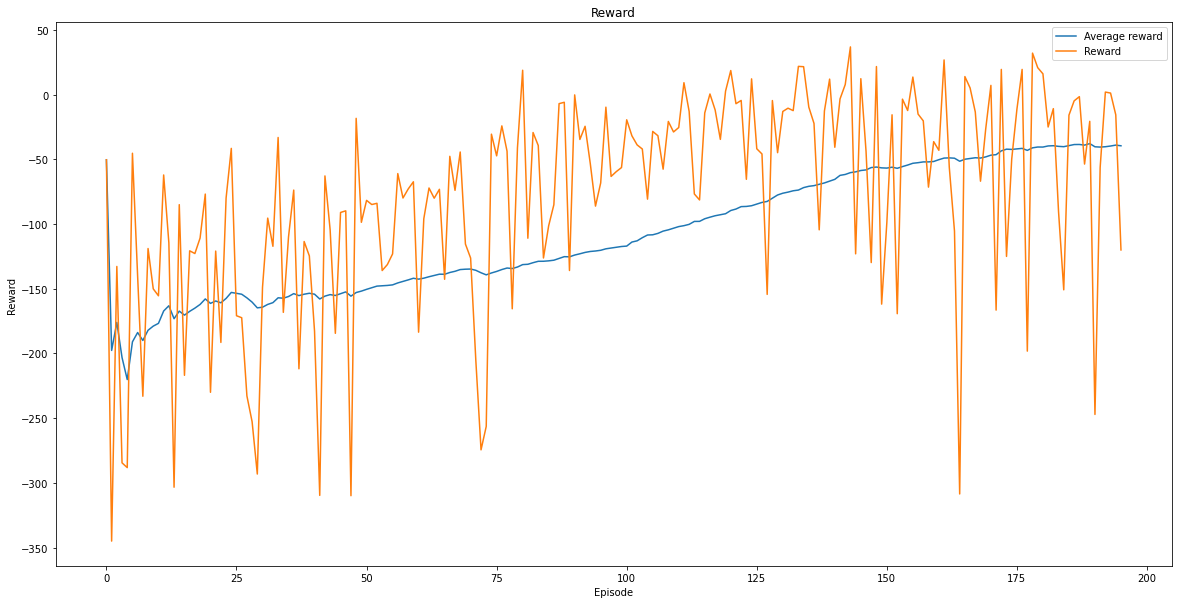

In [14]:
data = pd.read_csv(file_logger.file_name, sep=';')

plt.figure(figsize=(20,10))
plt.plot(data['average'])
plt.plot(data['reward'])
plt.title('Reward')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Average reward', 'Reward'], loc='upper right')
plt.show()

REFERENCES
1- https://wingedsheep.com/lunar-lander-dqn/